In [1]:
import re,random
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
with open(r"paul_graham_essays.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [3]:
# Marking Paragraphs
text = text.replace("\n\n", " <PARA> ")

# Data Cleaning
text = re.sub(r'[^a-zA-Z0-9. ]', ' ', text)
text = text.lower()
text = re.sub(r'\s+', ' ', text)
text = text.replace(".", " . ")

# Splitting paras
paragraphs = [p.strip() for p in text.split("<para>") if p.strip()]

processed_words = []

for para in paragraphs:
    words = para.split()
    new_words = []
    for w in words:
        new_words.append(w)
        if w == "." and random.random() < 0.4:  #This is done make our model such  that it also learns to stop
            new_words.append("<eos>")             #for example if i put a limit of 10 next word predictions,
    new_words.append("<eos>")                      #it should also do early prediction ends sometimes
    processed_words.extend(new_words)

print(f"Total words after processing: {len(processed_words)}")
print(f"Total <eos> tokens: {processed_words.count('<eos>')}")

# Vocab
word_counts = Counter(processed_words)
vocab = sorted(word_counts.keys())
vocab_size = len(vocab)
print(f" Vocab size: {vocab_size}")

#making sequences
sequence_length = 12
X, y = [], []

current_seq = []
for word in processed_words:
    if word == "<eos>":
        # Create sequences for all words before <eos>
        for i in range(len(current_seq)):
            start = max(0, i - sequence_length)
            seq = current_seq[start:i]
            seq = ["<empty>"] * (sequence_length - len(seq)) + seq
            X.append(seq)
            y.append(current_seq[i])

        # Add one extra sequence to predict <eos> after the last word
        if current_seq:
            seq = current_seq[-sequence_length:]
            seq = ["<empty>"] * (sequence_length - len(seq)) + seq
            X.append(seq)
            y.append("<eos>")

        current_seq = []  # reset context at paragraph end
    else:
        current_seq.append(word)

print(f"Total training sequences: {len(X)}")

# Examples
for i in range(20):
    print(f"X: {' '.join(X[i])} ---> y: {y[i]}")


Total words after processing: 634883
Total <eos> tokens: 13585
 Vocab size: 16657
Total training sequences: 634882
X: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> ---> y: para
X: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> para ---> y: essay
X: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> para essay ---> y: index
X: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> para essay index ---> y: .
X: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> para essay index . ---> y: <eos>
X: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> ---> y: html
X: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> html ---> y: paul
X: <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> html paul ---> y: graham
X: <empty> <empty> <empt

In [4]:
word_to_idx = {"<empty>": 0}
for idx, word in enumerate(vocab, start=1):
    word_to_idx[word] = idx
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

In [5]:
empty_idx = word_to_idx["<empty>"]

X_idx = [[word_to_idx.get(w, empty_idx) for w in seq] for seq in X]
y_idx = [word_to_idx.get(w, empty_idx) for w in y]

X_idx = torch.tensor(X_idx, dtype=torch.long)
y_idx = torch.tensor(y_idx, dtype=torch.long)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_idx, y_idx, test_size=0.1, random_state=42)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=4000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4000)

In [ ]:
class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=1024, seq_len=12, dropout=0.3, activation="relu"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embed_dropout = nn.Dropout(0.1)

        self.fc1 = nn.Linear(embed_dim * seq_len, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim // 2, vocab_size)

        if activation == "relu":
            self.act = nn.ReLU()
        elif activation == "tanh":
            self.act = nn.Tanh()
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        # 1. Embed tokens → shape: [batch_size, seq_len, embed_dim]
        embeds = self.embed_dropout(self.embedding(x))

        # 2. Flatten all embeddings into one long vector per sequence
        #    → shape: [batch_size, seq_len * embed_dim]
        flat = embeds.view(embeds.size(0), -1)

        # 3. Pass through MLP layers with activation + dropout
        h = self.act(self.fc1(flat))
        h = self.dropout(h)
        h = self.act(self.fc2(h))
        h = self.dropout(h)

        # 4. Output logits for vocabulary prediction → shape: [batch_size, vocab_size]
        out = self.fc_out(h)

        return out

In [8]:
# --- Step 9: Model, Loss, Optimizer ---
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MLPTextGenerator(
    vocab_size=len(word_to_idx),
    embed_dim=64,
    hidden_dim=1024,
    seq_len=12
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=1e-4 
)


Using device: cuda


In [9]:
train_losses, val_losses = [], []
epochs = 50

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Epoch 1/50 | Train Loss: 6.3388 | Val Loss: 5.8575
Epoch 2/50 | Train Loss: 5.6732 | Val Loss: 5.5960
Epoch 3/50 | Train Loss: 5.3831 | Val Loss: 5.4219
Epoch 4/50 | Train Loss: 5.1701 | Val Loss: 5.3161
Epoch 5/50 | Train Loss: 4.9985 | Val Loss: 5.2673
Epoch 6/50 | Train Loss: 4.8457 | Val Loss: 5.2288
Epoch 7/50 | Train Loss: 4.7105 | Val Loss: 5.2194
Epoch 8/50 | Train Loss: 4.5835 | Val Loss: 5.2207
Epoch 9/50 | Train Loss: 4.4739 | Val Loss: 5.2300
Epoch 10/50 | Train Loss: 4.3757 | Val Loss: 5.2455
Epoch 11/50 | Train Loss: 4.2927 | Val Loss: 5.2564
Epoch 12/50 | Train Loss: 4.2191 | Val Loss: 5.2730
Epoch 13/50 | Train Loss: 4.1559 | Val Loss: 5.2867
Epoch 14/50 | Train Loss: 4.1012 | Val Loss: 5.3013
Epoch 15/50 | Train Loss: 4.0494 | Val Loss: 5.3156
Epoch 16/50 | Train Loss: 4.0055 | Val Loss: 5.3310
Epoch 17/50 | Train Loss: 3.9613 | Val Loss: 5.3372
Epoch 18/50 | Train Loss: 3.9262 | Val Loss: 5.3586
Epoch 19/50 | Train Loss: 3.8925 | Val Loss: 5.3734
Epoch 20/50 | Train L

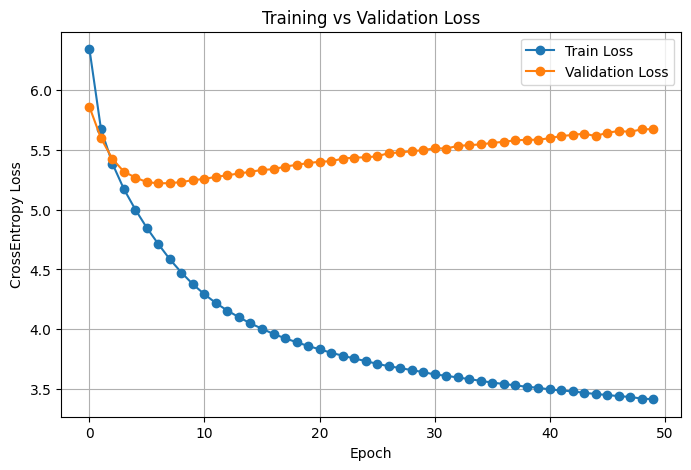


 Final Validation Loss: 5.6717
 Final Validation Accuracy: 21.07%


In [10]:
# TRAINING VS VALIDATION LOSS
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy Loss')
plt.legend()
plt.grid(True)
plt.show()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

val_accuracy = 100 * correct / total
print(f"\n Final Validation Loss: {val_losses[-1]:.4f}")
print(f" Final Validation Accuracy: {val_accuracy:.2f}%")

In [11]:
class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=1024, seq_len=12, dropout=0.3, activation="relu"):
        super().__init__()

        # --- Layers ---
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embed_dropout = nn.Dropout(0.1)

        self.fc1 = nn.Linear(embed_dim * seq_len, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim // 2, vocab_size)

        # --- Activation ---
        if activation == "relu":
            self.act = nn.ReLU()
        elif activation == "tanh":
            self.act = nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        # --- Weight Initialization ---
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """Initialize weights using Xavier initialization for linear layers."""
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        """
        Forward pass:
        - x: tensor of shape [batch_size, seq_len] (contains token indices)
        """
        # 1. Embed tokens → shape: [batch_size, seq_len, embed_dim]
        embeds = self.embed_dropout(self.embedding(x))

        # 2. Flatten all embeddings into one long vector per sequence
        #    → shape: [batch_size, seq_len * embed_dim]
        flat = embeds.view(embeds.size(0), -1)

        # 3. Pass through MLP layers with activation + dropout
        h = self.act(self.fc1(flat))
        h = self.dropout(h)
        h = self.act(self.fc2(h))
        h = self.dropout(h)

        # 4. Output logits for vocabulary prediction → shape: [batch_size, vocab_size]
        out = self.fc_out(h)

        return out

In [12]:
# --- Step 9: Model, Loss, Optimizer ---
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MLPTextGenerator(
    vocab_size=len(word_to_idx),
    embed_dim=64,
    hidden_dim=1024,
    seq_len=12,
    activation = "tanh"
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=1e-4 
)


Using device: cuda


In [13]:
train_losses, val_losses = [], []
epochs = 50

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Epoch 1/50 | Train Loss: 6.5914 | Val Loss: 6.0535
Epoch 2/50 | Train Loss: 5.8878 | Val Loss: 5.6941
Epoch 3/50 | Train Loss: 5.5989 | Val Loss: 5.5125
Epoch 4/50 | Train Loss: 5.3992 | Val Loss: 5.4014
Epoch 5/50 | Train Loss: 5.2464 | Val Loss: 5.3231
Epoch 6/50 | Train Loss: 5.1192 | Val Loss: 5.2661
Epoch 7/50 | Train Loss: 5.0115 | Val Loss: 5.2367
Epoch 8/50 | Train Loss: 4.9149 | Val Loss: 5.2100
Epoch 9/50 | Train Loss: 4.8296 | Val Loss: 5.1906
Epoch 10/50 | Train Loss: 4.7524 | Val Loss: 5.1729
Epoch 11/50 | Train Loss: 4.6821 | Val Loss: 5.1679
Epoch 12/50 | Train Loss: 4.6167 | Val Loss: 5.1565
Epoch 13/50 | Train Loss: 4.5548 | Val Loss: 5.1561
Epoch 14/50 | Train Loss: 4.4995 | Val Loss: 5.1546
Epoch 15/50 | Train Loss: 4.4485 | Val Loss: 5.1519
Epoch 16/50 | Train Loss: 4.3976 | Val Loss: 5.1567
Epoch 17/50 | Train Loss: 4.3532 | Val Loss: 5.1604
Epoch 18/50 | Train Loss: 4.3129 | Val Loss: 5.1640
Epoch 19/50 | Train Loss: 4.2751 | Val Loss: 5.1669
Epoch 20/50 | Train L

KeyboardInterrupt: 

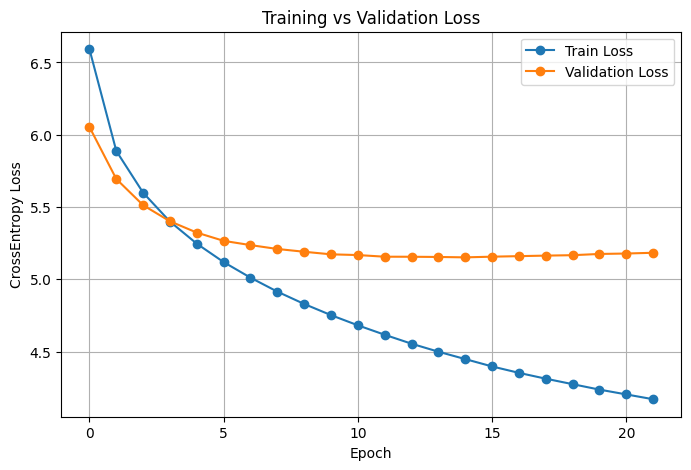


 Final Validation Loss: 5.1837
 Final Validation Accuracy: 20.23%


In [14]:
# TRAINING VS VALIDATION LOSS
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy Loss')
plt.legend()
plt.grid(True)
plt.show()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

val_accuracy = 100 * correct / total
print(f"\n Final Validation Loss: {val_losses[-1]:.4f}")
print(f" Final Validation Accuracy: {val_accuracy:.2f}%")